## Web Analytics Project ##
## Main goal - find insights about web page users ##

# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd

# Customers Insights

In [ ]:
from google.cloud import bigquery
client = bigquery.Client (project = 'webalab')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
df1 =client.query ('''

SELECT
  geo.sub_continent AS sub_continent,
  # geo.country AS country,
  COUNT(DISTINCT user_pseudo_id) AS unique_users,   --Counting how many users there are in each sub-continent
  COUNT(*) AS total_events,     --Counting how many events are triggered in total

FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  event_name IS NOT NULL

GROUP BY
  sub_continent
ORDER BY
  total_events DESC

''').to_dataframe()

df1

,sub_continent,unique_users,total_events
0,Northern America,48610,625454
1,Southern Asia,9805,118231
2,Eastern Asia,6310,83810
3,Western Europe,5817,75410
4,Northern Europe,4803,60934
5,Southern Europe,4242,54915
6,Southeast Asia,3993,48966
7,South America,2472,32811
8,Western Asia,2519,32618
9,Eastern Europe,2730,32461


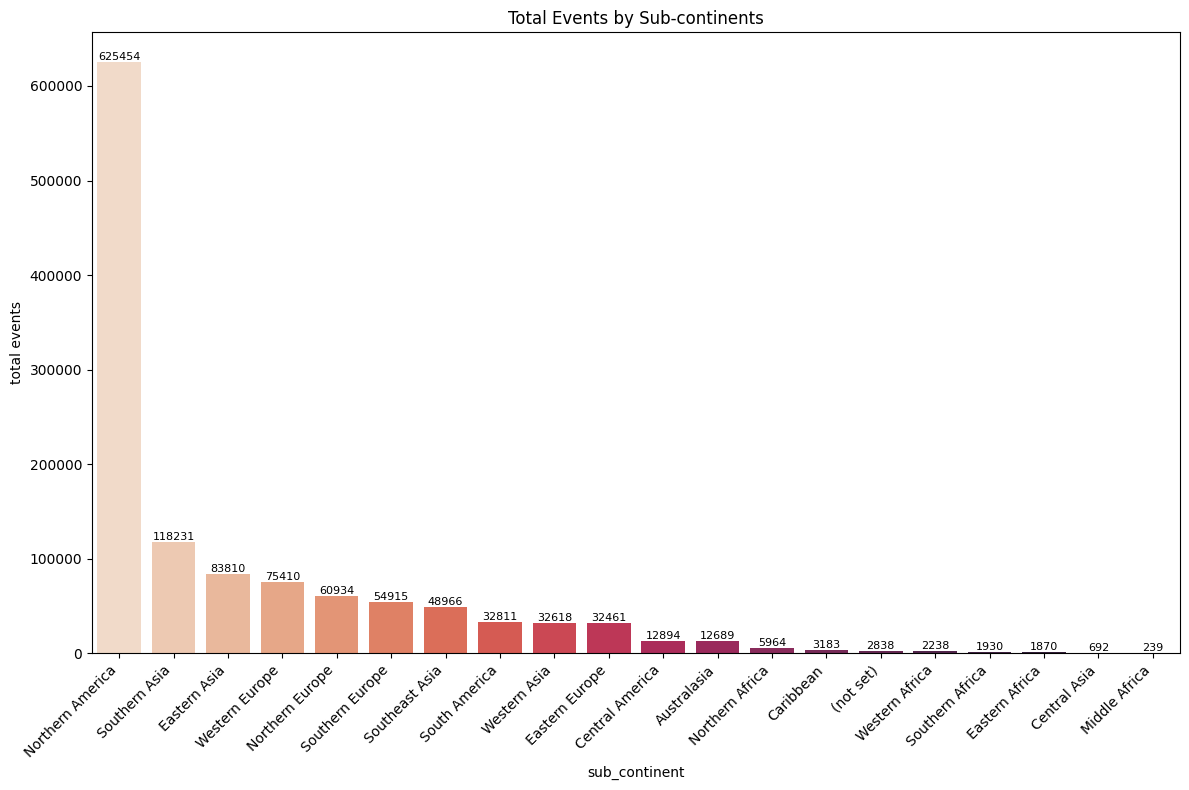

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='sub_continent', y='total_events', data=df1, palette='rocket_r')  ##This color kinda matches with the logo of Google Cloud, enjoy! ;)
plt.title('Total Events by Sub-continents')
plt.xlabel('sub_continent')
plt.ylabel('total events')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for index, value in enumerate(df1['total_events']):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=8)
plt.show()

We can clearly see that Nothern America had the highest volumn of events. So we will continue to focus on the users in Nothern America to see their behaviors.

## How is the performance between Number of Sessions and the time difference?


In [ ]:
df4= client.query ('''

WITH p1 AS (
  SELECT
    geo.sub_continent AS sub_continent,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_number') AS ga_session_number,
    user_pseudo_id,
    event_name,
    event_timestamp,
    LAST_VALUE(event_timestamp) OVER (PARTITION BY user_pseudo_id ORDER BY event_timestamp ASC
      ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS last_timestamp
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    event_name = 'session_start'
),

p2 AS (  --Calculating the time distance
  SELECT
    sub_continent,
    ga_session_number,
    (last_timestamp - event_timestamp) / 8.64e+10 AS distance,
    event_name,
    event_timestamp
  FROM
    p1
)

SELECT
  ga_session_number,
  COUNT(*) AS sessions,
  AVG(distance) AS average_distance  --Calculating average time distance
FROM
  p2
WHERE
  sub_continent = 'Northern America'
GROUP BY
  ga_session_number
ORDER BY
  ga_session_number

''').to_dataframe()

df4

,ga_session_number,sessions,average_distance
0,1,45577,0.344353
1,2,7085,1.091253
2,3,2674,1.740497
3,4,1474,2.228885
4,5,937,2.578607
5,6,620,2.654941
6,7,426,2.626721
7,8,304,3.134432
8,9,203,2.904841
9,10,161,2.379043


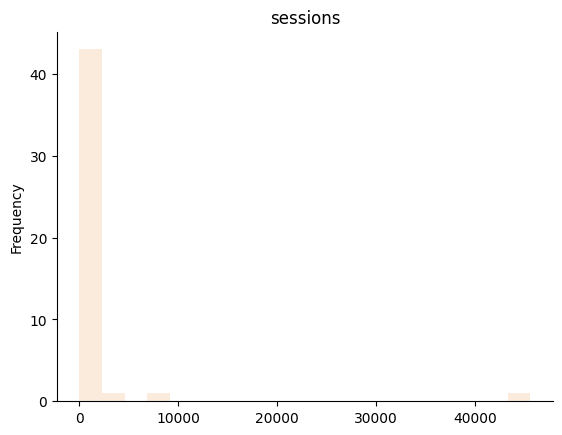

In [ ]:
df4['sessions'].plot(kind='hist', bins=20, title='sessions',cmap='rocket_r')
plt.gca().spines[['top', 'right',]].set_visible(False)

The majority of users have only one or a few sessions. "ga_session_number" 1 and 2 has the highest count.

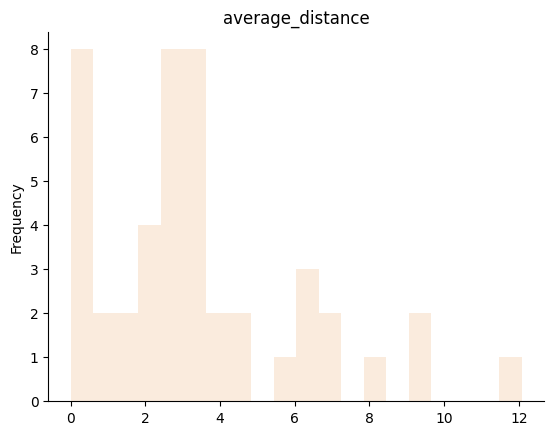

In [ ]:
df4['average_distance'].plot(kind='hist', bins=20, title='average_distance', cmap='rocket_r')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Are regular users more likely to purchase ?


In [ ]:
df20= client.query ('''

  SELECT
    user_pseudo_id,
    COUNT(DISTINCT (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_number')) AS total_sessions
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  GROUP BY
    user_pseudo_id

''').to_dataframe()

df20

,user_pseudo_id,total_sessions
0,1351203.1112076403,6
1,1367427.8021574339,10
2,1509167.8454878013,10
3,1651715.4830915079,7
4,2479425.7455743127,6
...,...,...
94785,40944107.7453628066,5
94786,2573730.4258579797,5
94787,7669851.9788206893,5
94788,51545355.2497176736,5


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


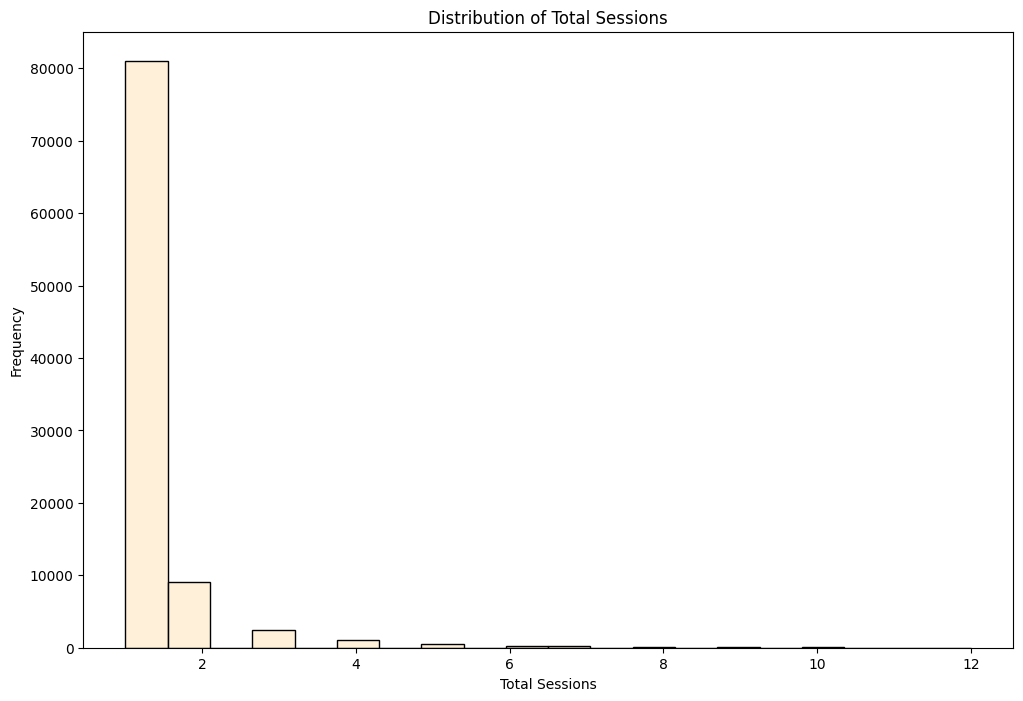

In [ ]:
plt.figure(figsize=(12, 8))
sns.histplot(df20['total_sessions'], bins=20,color='BlanchedAlmond')
plt.title('Distribution of Total Sessions')
plt.xlabel('Total Sessions')
plt.ylabel('Frequency')
plt.show()

As we can see, most users have less than 2 sessions. So we will set the 'Regular User' as session >2, others 'Non-Regular User'

In [ ]:
df21 = client.query('''
WITH p1 AS (
  SELECT
    user_pseudo_id,
    COUNT(DISTINCT (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_number')) AS total_sessions
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  GROUP BY
    user_pseudo_id
),

p2 AS (
  SELECT
    user_pseudo_id,
    COUNTIF(event_name = 'purchase') AS purchase_count
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    event_name = 'purchase'
  GROUP BY
    user_pseudo_id
)

SELECT
  CASE
    WHEN p1.total_sessions > 2 THEN 'Regular User'
    ELSE 'Non-Regular User'
  END AS user_type,
  COUNT(DISTINCT p1.user_pseudo_id) AS user_count,
  COUNT(DISTINCT p2.user_pseudo_id) AS purchase_user_count,
  COUNT(DISTINCT p2.user_pseudo_id) / COUNT(DISTINCT p1.user_pseudo_id) AS purchase_probability
FROM
  p1
LEFT JOIN
  p2
ON
  p1.user_pseudo_id = p2.user_pseudo_id
GROUP BY
  user_type
ORDER BY
  user_type
''').to_dataframe()

print(df21)

          user_type  user_count  purchase_user_count  purchase_probability
0  Non-Regular User       90094                  612              0.006793
1      Regular User        4696                  457              0.097317


As show, the Non-Regular User has a purchase_probability of 0.6793% while the Regular User has a purchase_probability at 9.7317%. To further ensure that the regular users are more likely to purchase, we can use an independent two-sample t-test to validate this conclusion:

In [ ]:
##Creating dataframes of the Non-regular users and Rugular users as two independent samples for t-test
## 1 for purchase, 0 for didn't purchase
NRU = {'purchase': [0]*(90094-612) + [1]*612}
df_NRU = pd.DataFrame(NRU)
RU = {'purchase': [0]*(4696-457) + [1]*457}
df_RU = pd.DataFrame(RU)


t_statistic, p_value = stats.ttest_ind(df_NRU['purchase'], df_RU['purchase'])
print(p_value)

0.0


Since the p-value is smaller than 0.05, we can say that at a significant level of 0.05, the average (i.e. the probability of purchase) is different. Regular users are more likely to purchase.

- Does the purchase behavior differ by hours in a day (for the users in United States)?

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project= 'webalab')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
df2 = client.query('''   ##Save the data of page_view in df2
    WITH prep1 AS (  --Calculating the number of the times when our target event happenned, preparing for the latter calculation of average
  SELECT
    EXTRACT(DAY FROM TIMESTAMP_MICROS(event_timestamp)) AS days,   --Recognize the information of dates
    EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hours,   --Recognize the information of hours
    COUNT(event_name) AS day_value
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    event_name = 'page_view'
    AND geo.country = 'United States'   --When we study on the time, it only makes sense when it is limited to a certain area
    -- Why the Americans? Because their behaviors worth being researched 👻 (No offense)

  GROUP BY
    days,hours
)

SELECT
  hours,
  AVG(day_value) AS hits
FROM
  prep1
GROUP BY
  hours
ORDER BY
  hours ASC;

''').to_dataframe()

print(df2)

    hours        hits
0       0  249.322581
1       1  251.225806
2       2  247.322581
3       3  245.645161
4       4  247.322581
5       5  255.387097
6       6  236.903226
7       7  239.451613
8       8  248.516129
9       9  252.677419
10     10  247.161290
11     11  245.483871
12     12  243.419355
13     13  255.322581
14     14  241.548387
15     15  235.354839
16     16  255.161290
17     17  251.967742
18     18  244.322581
19     19  252.677419
20     20  243.806452
21     21  265.032258
22     22  244.032258
23     23  263.612903


In [ ]:
df3 = client.query('''  ##Save the data of purchase in df3
    WITH prep1 AS (
  SELECT
    EXTRACT(DAY FROM TIMESTAMP_MICROS(event_timestamp)) AS days,
    EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hours,
    COUNT(event_name) AS day_value
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    event_name = 'purchase'   --Now let's talk about the behavior which is more meaningful
    AND geo.country = 'United States'  --When do ppl in the States prefer to buy stuff in this website?
  GROUP BY
    days,hours
)

SELECT
  hours,
  AVG(day_value) AS hits
FROM
  prep1
GROUP BY
  hours
ORDER BY
  hours ASC;


''').to_dataframe()

print(df3)

    hours      hits
0       0  1.909091
1       1  1.352941
2       2  1.818182
3       3  1.333333
4       4  2.000000
5       5  1.823529
6       6  1.600000
7       7  1.400000
8       8  1.454545
9       9  1.500000
10     10  1.230769
11     11  1.214286
12     12  1.000000
13     13  1.444444
14     14  1.466667
15     15  1.250000
16     16  1.357143
17     17  2.142857
18     18  1.687500
19     19  1.846154
20     20  1.333333
21     21  1.705882
22     22  1.333333
23     23  1.583333


Text(0, 0.5, 'Times of view')

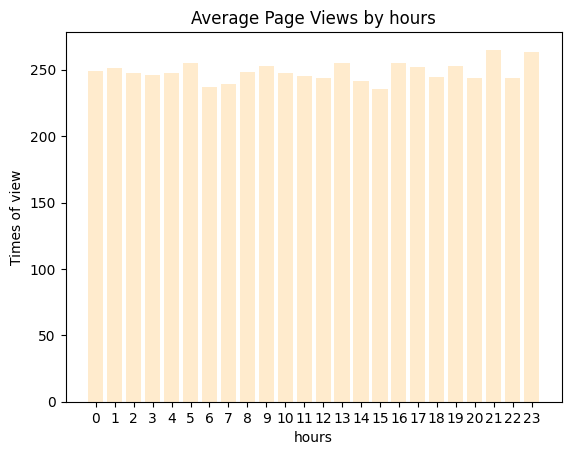

In [ ]:
plt.bar(df2['hours'],df2['hits'],color='BlanchedAlmond')   ##Print a bar chart of averaged page_view by hours
plt.title('Average Page Views by hours')
plt.xticks(np.arange(0, 24, 1))  ##To show every hour in x-axis
plt.xlabel('hours')
plt.ylabel('Times of view')

Text(0, 0.5, 'Times of Purchase')

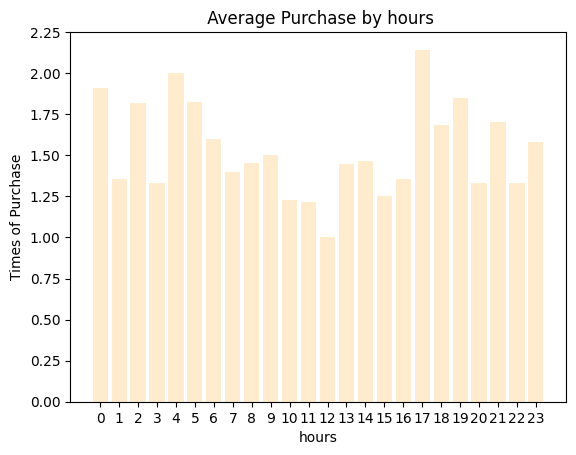

In [ ]:
plt.bar(df3['hours'],df3['hits'],color='BlanchedAlmond')   ##Print a bar chart of averaged purchase by hours
plt.title(' Average Purchase by hours')
plt.xticks(np.arange(0, 24, 1))  ##To show every hour in x-axis
plt.xlabel('hours')
plt.ylabel('Times of Purchase')

We can see that the number of the times of purchase peaks at 17:00. Is it significantly different from the average level in a day? To figure this out, we need to perform a one-sample t-test as follows:

In [ ]:
peak = np.max(df3['hits'])

t_statistic, p_value = stats.ttest_1samp(df3['hits'], peak)  ##1-sample t-test
print(p_value)

2.5836456485605687e-10


Since p-value is way smaller than 0.05, we say that at a significant level of 0.05, the times of purchase at 17:00 is significantly higher than the average level in a day.

# Which is the promotion that triggered the most purchases?

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='webalab')

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
df11 = client.query('''
SELECT
  (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'promotion_name') AS promotion,
  COUNT(*) AS TotalPurchases
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  event_name = 'purchase'
GROUP BY
  promotion
ORDER BY
  TotalPurchases DESC;

  ''').to_dataframe()

df11

,promotion,TotalPurchases
0,None,779
1,reach new heights,188
2,google mural collection,89
3,act responsible,79
4,complete your collection,69


In [ ]:
df12 = df11.iloc[1:]   ##Removing the row with 'None'

df12

,promotion,TotalPurchases
1,reach new heights,188
2,google mural collection,89
3,act responsible,79
4,complete your collection,69


([0, 1, 2, 3],
 [Text(0, 0, 'reach new heights'),
  Text(1, 0, 'google mural collection'),
  Text(2, 0, 'act responsible'),
  Text(3, 0, 'complete your collection')])

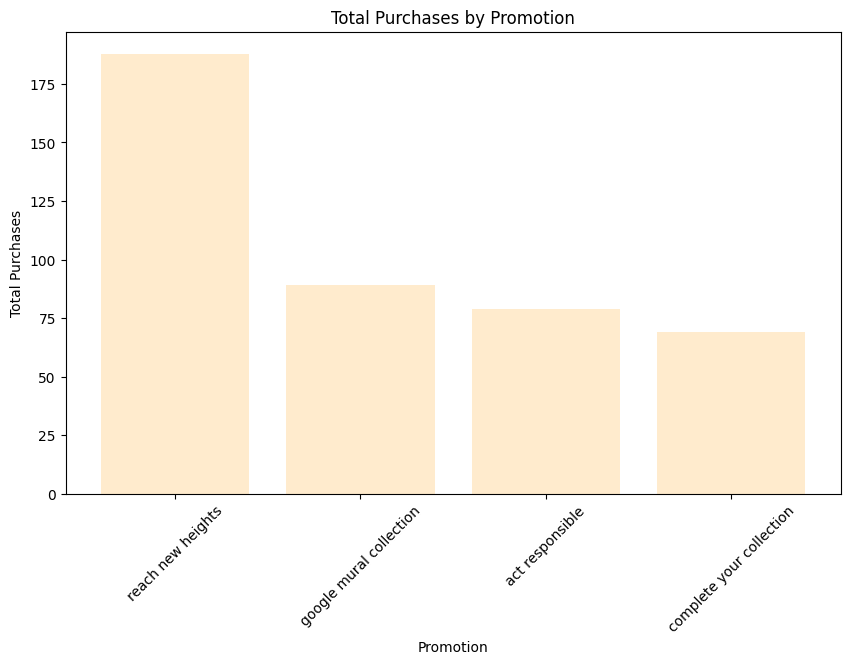

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df12['promotion'], df12['TotalPurchases'], color='BlanchedAlmond')

plt.xlabel('Promotion')
plt.ylabel('Total Purchases')
plt.title('Total Purchases by Promotion')
plt.xticks(rotation=45)

From the bar chart we could see that the promotion 'reach new heights' drove much more purchases than other promotions.


Furthermore, we wonder how much time it takes for a purchase to be done under a 'reach new heights' promotion.

## How much time does it take for a purchase to be done after the first touch under a 'reach new heights' promotion?

In [ ]:
df41 = client.query('''
with p1 as(
  SELECT
  event_timestamp,
  user_first_touch_timestamp,
  user_pseudo_id,
  (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'promotion_name') AS promotion,
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
  event_name = 'purchase'
GROUP BY
  promotion,
  user_pseudo_id,
  event_timestamp,
  user_first_touch_timestamp
),

p2 as(
  SELECT
  first_value(event_timestamp) over (partition by user_pseudo_id order by event_timestamp asc
  rows between unbounded preceding and unbounded following)
  as first_purchase,
  *
  FROM
    p1
  WHERE
    promotion = "reach new heights"  --Extracting the first time of purchase under this promotion
)

SELECT
(first_purchase - user_first_touch_timestamp)/8.64e+10 AS distance   --Calculating the distance
FROM
  p2


  ''').to_dataframe()

df41

,distance
0,4.892871
1,17.134695
2,16.704648
3,0.004829
4,40.958895
...,...
183,0.017763
184,370.802913
185,107.891679
186,0.021749


In [ ]:
df41.describe()

,distance
count,185.000000
mean,32.083493
std,66.417125
min,0.001712
25%,0.013775
50%,1.508889
75%,25.982638
max,382.078042


- For users who were associated with the "reach new heights" promotion, it takes 32 days on average to conduct the first purchase. The minimum is within 1 day and the maximum is more than a year. The median is around 1.5 days.